In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
def custom_conv2d(input_tensor, kernel, stride=1, padding=0, dilation=1):
    batch_size, in_channels, height, width = input_tensor.shape
    out_channels, _, kernel_height, kernel_width = kernel.shape

    input_tensor_padded = np.pad(input_tensor, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')

    output_height = (height + 2 * padding - dilation * (kernel_height - 1) - 1) // stride + 1
    output_width = (width + 2 * padding - dilation * (kernel_width - 1) - 1) // stride + 1

    output = np.zeros((batch_size, out_channels, output_height, output_width))

    for batch in range(batch_size):
        for o in range(out_channels):
            for h in range(output_height):
                for w in range(output_width):
                    for i in range(in_channels):
                        h_start = h * stride
                        w_start = w * stride
                        h_end = h_start + dilation * (kernel_height - 1) + 1
                        w_end = w_start + dilation * (kernel_width - 1) + 1

                        input_region = input_tensor_padded[batch, i, h_start:h_end:dilation, w_start:w_end:dilation]
                        output[batch, o, h, w] += np.sum(input_region * kernel[o, i, :, :])

    return output


Number of output mismatches: 0 out of 1000 trials


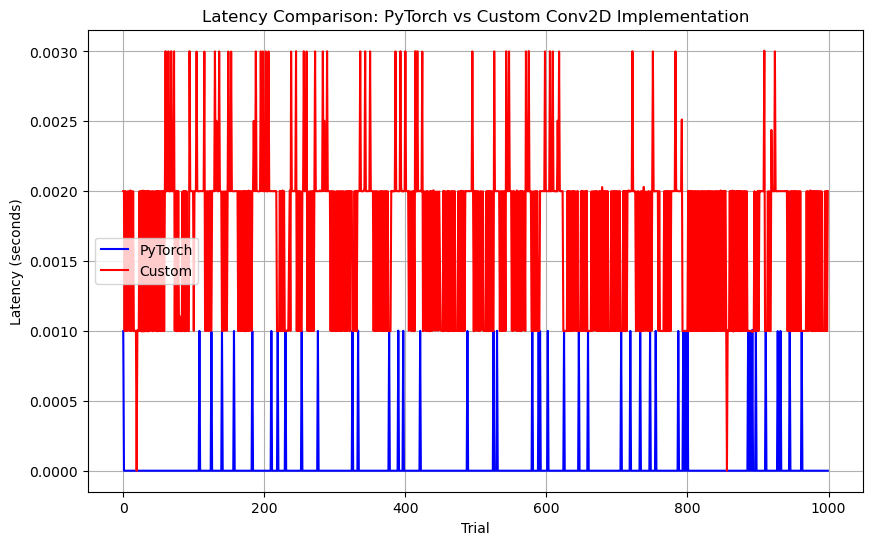

In [4]:
def measure_latency():

    batch_size = 1
    in_channels = 1
    out_channels = 1
    kernel_size = 3
    input_size = 32

    stride = 2
    padding = 1
    dilation = 1


    input_tensor = torch.randn(batch_size, in_channels, input_size, input_size)
    kernel = torch.randn(out_channels, in_channels, kernel_size, kernel_size)


    conv2d_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False)
    conv2d_layer.weight = torch.nn.Parameter(kernel)  

    pytorch_times = []
    custom_times = []
    output_comparisons = [] 

    for _ in range(1000):
    
        start_time = time.time()
        with torch.no_grad():
            pytorch_output = conv2d_layer(input_tensor)
        pytorch_times.append(time.time() - start_time)

   
        start_time = time.time()
        custom_output = custom_conv2d(input_tensor.numpy(), kernel.numpy(), stride=stride, padding=padding, dilation=dilation)
        custom_times.append(time.time() - start_time)

  
        custom_output_tensor = torch.tensor(custom_output).float()


        are_outputs_close = torch.allclose(pytorch_output, custom_output_tensor, atol=1e-4)
        output_comparisons.append(are_outputs_close)

    print(f"Number of output mismatches: {output_comparisons.count(False)} out of 1000 trials")

    return pytorch_times, custom_times

def plot_latency_comparison(pytorch_times, custom_times):
    plt.figure(figsize=(10, 6))

    plt.plot(pytorch_times, label="PyTorch", color='blue')
    plt.plot(custom_times, label="Custom", color='red')

    plt.xlabel('Trial')
    plt.ylabel('Latency (seconds)')
    plt.title('Latency Comparison: PyTorch vs Custom Conv2D Implementation')
    plt.legend()
    plt.grid(True)

    plt.show()

def main():
    pytorch_times, custom_times = measure_latency()
    plot_latency_comparison(pytorch_times, custom_times)

main()